<a href="https://www.kaggle.com/code/jondelacruz/student-satisfaction-and-academic-performance?scriptVersionId=254341150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Exploring Student Satisfaction and Perceived Academic Performance in Remote Learning

## 1. Background
### 1.1 Introduction 

As we reflected on the challenges faced by students in a remote learning environment during the COVID-19 pandemic, several key issues emerged. These included unreliable internet connectivity and the absence of appropriate learning devices, which hindered participation in synchronous classes and the submission of course requirements (Baticulon et al., 2020; Santos, 2020). Negative experiences such as limited engagement in synchronous lectures, increased distractions, difficulties in comprehending lessons, and delays in the exchange of responses and feedback also significantly impacted their overall learning experience (Bai et al., 2021). Furthermore, two surveys conducted by the UP System Committee on Remote Teaching and Learning in November 2020 and July 2021 revealed that 80% of students felt academically overwhelmed, while only 30% expressed satisfaction with their learning experiences (Lontoc, 2021).

In response to this dilemma, it is crucial to evaluate the academic effectiveness of prior remote learning systems to assist administrations in their decision-making processes. As highlighted by Joaquin et al. (2020), learning innovations must have a deeper understanding of what remote education is by looking at factors such as instructor’s capacity, student’s circumstance, and learning environment efficiency together with the more evident issues of network connection speed, cost of materials, and mode of instruction.

### 1.2. Objectives

The main objective of this report was to analyze student responses from a survey on remote learning using exploratory and factor analyses. Specifically, it aims to:
             
1.	Describe respondents by demographics, student satisfaction with remote learning, and perceived academic performance.
3.	Examine relationships between the three aforementioned set of variables.
4.	Identify the best latent factor structure for student satisfaction with remote learning.

## 2. Exploratory Analysis

In [1]:
## Import data from CSV file
suppressMessages(library(tidyverse)) # required library
data <- read_csv("/kaggle/input/the-data-setlist/survey_data.csv", show_col_types = FALSE)


## Create functions to be used
library(dplyr) # required library

# Tabularize a dataframe

library(DT)
summarize_variable <- function(data, variable=NULL, caption=NULL, dom="t", searching=FALSE, rownames=FALSE, pageLength=10) {
  if (is.null(variable)) {
    datatable(data, 
                  class="cell-border stripe", 
                  options = list(dom=dom, searching=searching, pageLength=pageLength),
                  rownames=rownames,
                  caption=if (!is.null(caption)) htmltools::tags$caption(
                    style = 'caption-side: top; text-align: center;',
                    caption
                  ) else NULL)
  } else {
	summarized_data <- data %>%
      filter(!!sym(variable) != "No Data") %>%
      group_by(!!sym(variable)) %>%
      summarise(Count = n(), .groups="drop") %>%
      {
        if (is.ordered(data[[variable]])) {
          arrange(., desc(!!sym(variable)))
        } else {
          arrange(., desc(Count))
        }
      } %>%
      mutate(Percentage = label_percent(accuracy=0.01)(Count/sum(Count)))
    
    datatable(summarized_data %>% rename(!!variable := !!sym(variable)),
                  class="cell-border stripe", 
                  options = list(dom=dom, searching=searching, pageLength=pageLength),
			      rownames=rownames,
                  caption=if (!is.null(caption)) htmltools::tags$caption(
                    style = 'caption-side: top; text-align: center;',
                    caption
                  ) else NULL)
  }
}
          

# Create horizontal bar plot using base R graphics    
suppressMessages(library(rlang, verbose=FALSE, quiet=TRUE)) # required library               
horiz_barplot <- function(data,
                          variable,
                          summ_var = NULL,
                          summ_fun = "n",
                          na.rm = TRUE,
                          others = FALSE,
                          others.p = NULL,
                          mar = c(5.1, 4.1, 4.1, 2.1),
                          col = "steelblue",
                          title = NULL,
                          xlab = NULL,
                          ylab = NULL,
                          xlim_adj = 0,
                          ...) {

  # --- 1. Data Summarization ---

  # Use dplyr::count() for simple counts.
  if (is.null(summ_fun) || summ_fun == "n" || is.null(summ_var)) {
    summary_col_name <- "Count"
    
    summarized_data <- data %>%
      count(.data[[variable]], name = summary_col_name, sort = TRUE)

  } else {
    # Handle other summary functions (mean, median, etc.)
    summary_col_name <- paste(summ_fun, summ_var, sep = "_")
    
    summarized_data <- data %>%
      group_by(.data[[variable]]) %>%
      summarize(
        !!summary_col_name := get(summ_fun)(.data[[summ_var]], na.rm = na.rm),
        .groups = "drop"
      ) %>%
      arrange(desc(.data[[summary_col_name]]))
  }
  
  # --- 2. "Others" Grouping ---
  if (others && !is.null(others.p)) {
    
    # Identify which rows to keep and which to group into "Others"
    to_keep <- summarized_data %>% filter(.data[[summary_col_name]] > others.p)
    to_group <- summarized_data %>% filter(.data[[summary_col_name]] <= others.p)
    
    # Only proceed if there are categories to group
    if (nrow(to_group) > 0) {
      others_row <- tibble(
        # Set the category name to "Others"
        !!variable := "Others",
        # Sum the values of the grouped categories
        !!summary_col_name := sum(to_group[[summary_col_name]])
      )
      
      # Combine the rows to keep with the new "Others" row
      summarized_data <- bind_rows(to_keep, others_row)
    }
  }

  # --- 3. Prepare Data for Base R Plotting ---
  # `barplot` requires a named vector.
  
  # Ensure the variable column is character for naming
  summarized_data[[variable]] <- as.character(summarized_data[[variable]])
  
  # Create the named vector
  summary_vec <- setNames(summarized_data[[summary_col_name]], summarized_data[[variable]])
  
  # Reverse the vector so the largest bar is at the top of the plot
  summary_vec <- rev(summary_vec)

  # --- 4. Generate Base R Plot ---
  
  # Set graphical margins
  par(mar = mar)
  
  # Display the bar plot
  bar_midpoints <- barplot(
    height = summary_vec,
    col = col,
    horiz = TRUE,
    las = 1, # Make category labels horizontal
    xlab = xlab,
    ylab = ylab,
    xlim = c(0, max(summary_vec) + xlim_adj),
    ...
  )
  
  # Add title and text labels for the bar values
  title(main = title, adj = 0, ...)
  text(
    x = summary_vec,
    y = bar_midpoints,
    labels = round(summary_vec, 1), # Round labels for cleanliness
    pos = 4, # Position labels to the right of the bars
    ...
  )
  
  # Return the bar midpoints, which can be useful
  invisible(bar_midpoints)
}

# Create custom mode function
mode <- function(x) {
  uniq_vals <- unique(x)
  uniq_vals[which.max(tabulate(match(x, uniq_vals)))]
}
              
            
## Data Understanding

# View the data
head(data)
tail(data)

# View column names
colnames(data)

# Check for missing values
sum(is.na(data))


## Data Preparation

# Define the standardization function for program variable
standardize_program <- function(input_text) {
  cleaned <- str_to_title(input_text)
    
  cleaned <- str_replace_all(cleaned, "Bs ", "BS ")
  cleaned <- str_replace_all(cleaned, "Vs ", "BS ")
  cleaned <- str_replace_all(cleaned, "Ba ", "BA ")
  cleaned <- str_replace_all(cleaned, " Of ", " of ")
  cleaned <- str_replace_all(cleaned, " In ", " in ")
  cleaned <- str_replace_all(cleaned, " And ", " and ")
  cleaned <- str_replace_all(cleaned, "BS in", "BS")
  cleaned <- str_replace_all(cleaned, "Bachelor of Science in", "BS")
  cleaned <- str_replace_all(cleaned, "Bachelor of", "B")

  if (str_detect(cleaned, "^BA Social Science") &&
      str_detect(cleaned, "Economics")) {
    return("BA Social Sciences (Economics)")
  } else if (str_detect(cleaned, "^B Secondary Education")) {
    return("B Secondary Education")
  } else if (str_detect(cleaned, "^BS Biology")) {
    return("BS Biology")
  } else if (str_detect(cleaned, "^Bfa")) {
    return("B Fine Arts")
  } else {
    return(cleaned)
  }
}

# Clean the data
data <- data %>%
    mutate(
        program = sapply(program, standardize_program), # Standardize program column
        constituent = str_replace(constituent, "Banos", "Baños"), # "Banos" to "Baños" in constituent column
        year_standing = factor(year_standing, levels = c("I", "II", "III", "IV", "V"), ordered = TRUE)  
    )        


## Feature Understanding

# Create a dataframe of descriptions for student information
studentInfo_descr <- data.frame(
    variable = c("id", "constituent", "program", "year_standing", "lms"),
    description = c(
        "Unique identification number assigned to a student participant",
        "UP constituent university where a student was enrolled at the time of the survey",
        "Degree program of a student at the time of the survey",
        "Year level standing of a student at the time of the survey",
        "Learning Management System/s used by a student in virtual classes at the time of the survey"
    )
)

# Subset data of student information
studentInfo_wide <- data[, studentInfo_descr$variable]
              
# Create a dataframe of descriptions for UPSSS variables
upsss_descr <- data.frame(
    item_code = c(
        "upsss1", "upsss2", "upsss3", "upsss4", "upsss5", "upsss6", "upsss7", "upsss8", 
        "upsss9", "upsss10", "upsss11", "upsss12", "upsss13", "upsss14", "upsss15", 
        "upsss16", "upsss17", "upsss18", "upsss19", "upsss20"
    ),

    variable = c(
      "lms_org", "lms_stable", "lms_prog_track",
      "prof_content", "prof_tools_eff",
      "course_workload", "course_announce",
      "course_req_time", "course_feedback_time",
      "sync_stable", "prof_compassion",
      "lib_content", "lib_update", "uni_services",
      "reg_smooth", "enlist_success", "sem_length",
      "uni_response", "setup_conducive", "sat_overall"
    ),
    
    short_description = c(
        "Organization of the LMS", "Stability and reliability of the LMS", "LMS capability for progress tracking",
        "Provision of necessary learning content", "Instructors' effective use of tools",
        "Reasonableness of the course workload", "Timeliness of course announcements",
        "Sufficient time to complete requirements", "Timeliness of feedback on submissions",
        "Stability of synchronous classes", "Instructors' compassion for student concerns",
        "Availability of needed online library content", "Timeliness of online library content", "Utility of university-provided services", 
        "Smoothness of the registration process", "Success in enlisting required courses", "Adequacy of the semester's length",
        "University's response to student concerns", "Conduciveness of the remote learning setup", "Overall satisfaction with remote learning setup"
    ),
    
    full_description = c(
        "Most of my professors organized a platform (e.g. UVLe, Google Classroom, Canvas, etc.) in such a way that I can easily find the content that I need.",
        "Most of my professors used a platform (e.g. UVLe, Google Classroom, Canvas, etc.) that is reliable, stable, and secure.",
        "Most of my professors used a platform (e.g. UVLe, Google Classroom, Canvas, etc.) for me to keep track of my learning progress.",
        "Most of my professors provided the content that I need to learn the lessons (e.g. lecture notes, zoom recordings, video lectures, etc.).",
        "In general, my professors utilized the available tools and platforms effectively.",
        "Most of my professors assigned a reasonable amount of course requirements.",
        "Most of my professors announced the details of requirements according to the date stated in the course schedule.",
        "Most of my professors gave a sufficient amount of time to accomplish the course requirements.",
        "Most of my professors provided feedback to my submissions in a justifiable time.",
        "Most of my professors carried out synchronous classes in a stable and smooth manner.",
        "Most of my professors were compassionate in hearing the students' concerns about their courses and current well-being.",
        "I accessed the university's online library which provides the content that I need (e.g. journals, references, etc.).",
        "I accessed the university's online library which provides up-to-date content.",
        "I used the available services provided by the university in my study (e.g. UP mail can be used to access free Office, Canva for Education, unlimited Google Drive storage, etc.).",
        "The university's registration process was smooth and straightforward.",
        "I enlisted all the subjects that I needed in this semester.",
        "The semester's length is adequate.",
        "The university hears the students' concerns when it comes to issues such as academic ease due to our current situation.",
        "I believe the university's remote learning setup was organized in a way that is conducive to learning.",
        "As a whole, I am satisfied with the university's remote learning setup this semester."
    )
)

# Subset UPSSS data  
upsss_wide <- data[, names(data) == "id" | grepl("upsss", names(data))]
upsss_items <- (colnames(data))[grepl("upsss", colnames(data))]
              
# Reshape data

suppressMessages(library(tidyr, verbose=FALSE, quiet=TRUE)) # required library
suppressMessages(library(reshape2, verbose=FALSE, quiet=TRUE)) # required library

upsss_long <- melt(
        upsss_wide,
        id.vars="id",
        variable.name="item_code",
        value.name="rating"
    ) %>%
    left_join(upsss_descr, by="item_code") %>%
    mutate(item_code = factor(item_code, levels=upsss_items, ordered = TRUE)) %>%
    inner_join(studentInfo_wide, "id")


# Create a dataframe of descriptions for SPAPS variables
spaps_descr <- data.frame(
    item_code = c(
        "spaps1", "spaps2", "spaps3", "spaps4", "spaps5", "spaps6", "spaps7"
     ),

    variable = c(
        "req_submit_time",
        "critical_thinking",
        "feedback_exchange",
        "feedback_apply",
        "course_obj_achieve",
        "study_daily",
        "gwa_expected"
    ),
    
    short_description = c(
        "Timely submission of requirements",
        "Application of critical thinking",
        "Providing and receiving feedback", 
        "Application of received feedback", 
        "Achievement of course objectives",        
        "Maintenance of a daily study habit",
        "Expectation of high GWA (1.75 or better)"        
    ),
    
    full_description = c(
        "I was able to submit all my requirements this semester on time.",
        "I was able to think critically and logically while doing my requirements.",
        "I was able to provide and receive feedback on my requirements.",
        "I was able to apply the feedback that I received.",
        "I was able to achieve all of my courses’ objectives.",
        "I made sure that I study for my courses every day.",
        "I believe I can get a general weighted average (GWA) of at least 1.75 this semester."
    )
        
)

# Subset SPAPS data  
spaps_wide <- data[, names(data) == "id" | grepl("spaps", names(data))]
spaps_items <- (colnames(data))[grepl("spaps", colnames(data))]

# Reshape data
spaps_long <- melt(
        spaps_wide,
        id.vars="id",
        measure.vars=spaps_items,
        variable.name="item_code",
        value.name="rating"
    ) %>%
    left_join(spaps_descr, by="item_code") %>%
    mutate(item_code = factor(item_code, levels = spaps_items, ordered=TRUE)) %>%
    inner_join(studentInfo_wide, "id")

id,constituent,program,year_standing,lms,upsss1,upsss2,upsss3,upsss4,upsss5,⋯,upsss18,upsss19,upsss20,spaps1,spaps2,spaps3,spaps4,spaps5,spaps6,spaps7
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001,UP Diliman,BS Statistics,III,UVLê,6,5,6,6,6,⋯,1,3,3,5,3,4,3,2,3,5
002,UP Diliman,BS Geology,IV,UVLê;Google Classroom,5,4,6,2,4,⋯,1,1,2,2,3,3,4,3,1,1
003,UP Diliman,B Music,V,UVLê;Google Classroom,6,6,6,7,7,⋯,1,5,6,5,7,7,7,7,4,7
004,UP Diliman,BS Statistics,IV,UVLê,6,7,7,5,6,⋯,1,2,1,4,5,5,5,5,4,5
005,UP Diliman,BS Biology,II,UVLê,7,7,7,7,7,⋯,2,3,4,4,6,6,6,5,4,7
006,UP Diliman,BS Statistics,IV,UVLê;Google Classroom,7,7,7,6,5,⋯,3,4,5,5,2,3,4,5,6,4


id,constituent,program,year_standing,lms,upsss1,upsss2,upsss3,upsss4,upsss5,⋯,upsss18,upsss19,upsss20,spaps1,spaps2,spaps3,spaps4,spaps5,spaps6,spaps7
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
145,UP Diliman,BS Statistics,III,UVLê,6,6,6,6,6,⋯,5,5,5,3,6,5,5,4,4,4
146,UP Diliman,BS Mechanical Engineering,III,UVLê;Google Classroom,7,7,7,5,5,⋯,3,2,2,2,4,3,5,1,4,3
147,UP Los Banos,BS Biology,II,eLBI;Google Classroom;Canvas;Moodle,7,7,7,7,7,⋯,1,2,1,1,3,2,1,3,1,7
148,UP Diliman,BS Computer Science,II,UVLê;Google Classroom,6,7,6,7,7,⋯,2,4,4,6,6,6,5,4,5,5
149,UP Diliman,BS Statistics,IV,UVLê;Google Classroom,7,7,6,7,7,⋯,1,5,3,6,7,5,7,5,2,7
150,UP Diliman,BS Business Administration and Accountancy,IV,UVLê;Google Classroom,5,5,6,5,4,⋯,1,2,2,7,6,2,2,4,2,1


[1] "id"            "constituent"   "program"       "year_standing"
 [5] "lms"           "upsss1"        "upsss2"        "upsss3"       
 [9] "upsss4"        "upsss5"        "upsss6"        "upsss7"       
[13] "upsss8"        "upsss9"        "upsss10"       "upsss11"      
[17] "upsss12"       "upsss13"       "upsss14"       "upsss15"      
[21] "upsss16"       "upsss17"       "upsss18"       "upsss19"      
[25] "upsss20"       "spaps1"        "spaps2"        "spaps3"       
[29] "spaps4"        "spaps5"        "spaps6"        "spaps7"

[1] 0

### 2.1. Descriptive Statistics
#### 2.1.1. Demographics

##### 2.1.1.1. Constituent University
Among the 150 surveyed UP students, 103 (68.7%) were from Diliman and 30 (20.0%) were from Los Baños. The remaining 17 respondents were from five other constituent universities: 5 (3.3%) from Manila, 4 (2.7%) from Baguio, 3 (2.0%) each from the Open University and Visayas, and 2 (1.3%) from Cebu.

##### 2.1.1.2. Undergraduate Program
Most of the respondents, totaling 66 (44.0%), were BS Statistics majors. The remaining 84 respondents came from a variety of other programs, including:
- 7 (4.7%) from BS Biology
- 6 (4.0%) from BS Secondary Education
- 5 (3.3%) each from three BS engineering programs (Civil, Computer Science, and Geodetic)
- 3 (2.0%) each from five BS programs: Business Economics, Development Communication, Economics, Mechanical Engineering, and Nursing
- 2 (1.3%) each from eight programs
- 1 (0.7%) each from 25 other programs

##### 2.1.1.3. Year Level Standing
Seniors made up the largest group with 52 (34.7%), followed by juniors (46 or 30.7%), sophomores (31, 20.7%), freshmen (17, 11.3%), and fifth-year students (4, 2.7%).

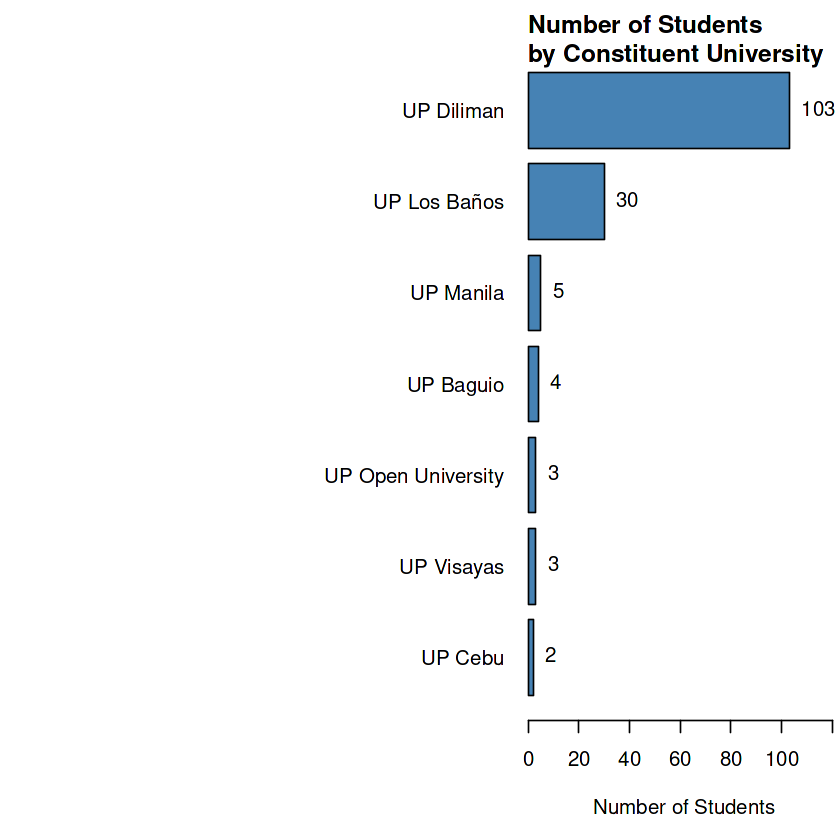

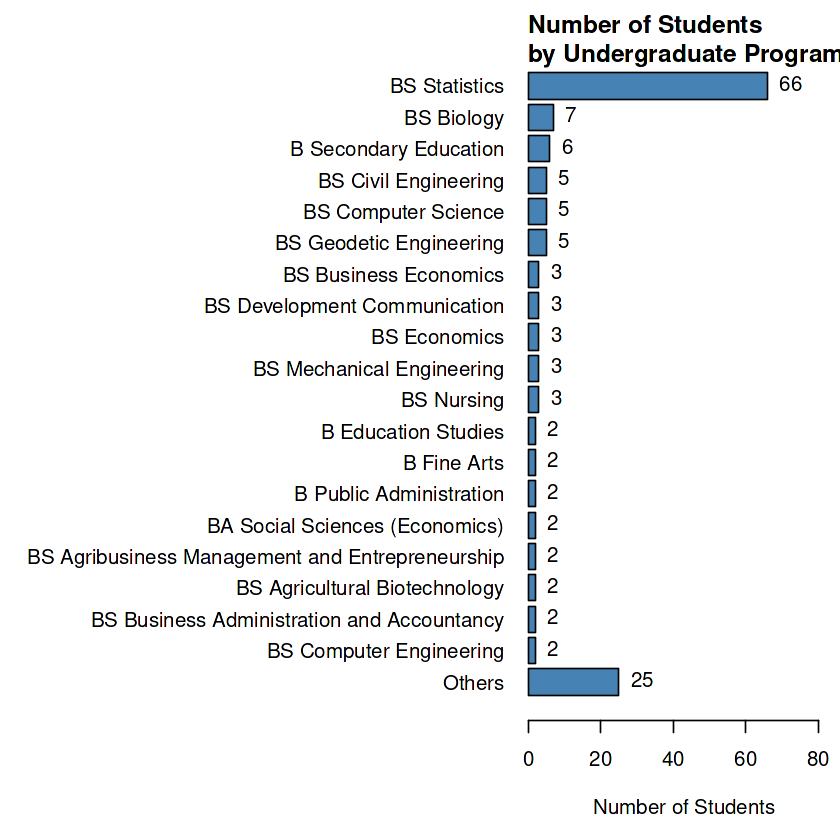

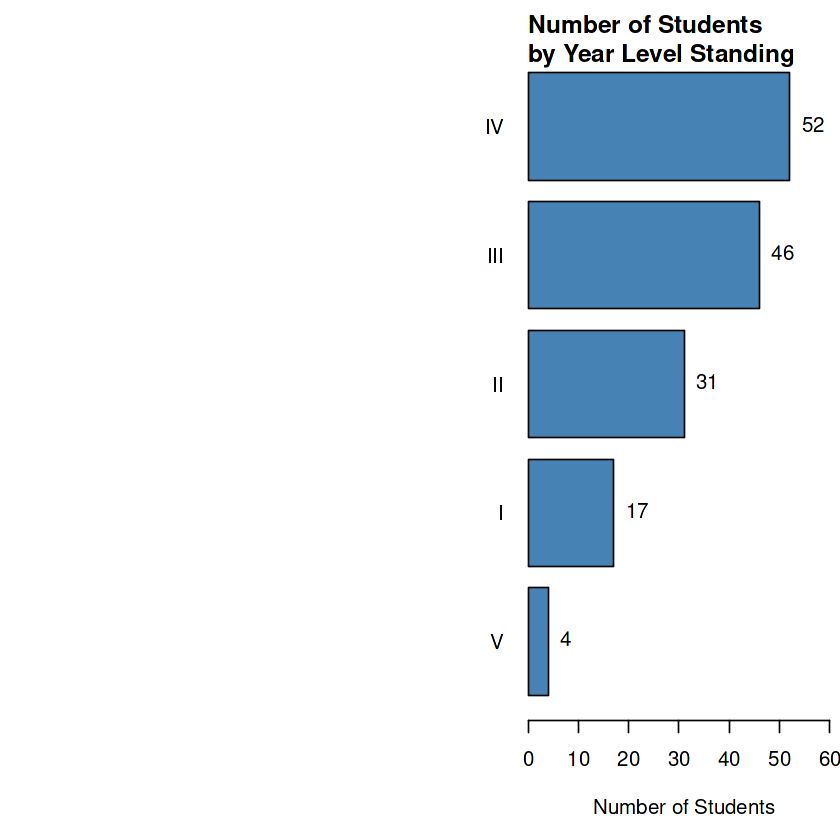

In [2]:
# Display bar plots

horiz_barplot(
  data = data,
  variable = "constituent",
  title = "\nNumber of Students\nby Constituent University",
  xlab = "Number of Students",
  mar = c(5, 22, 2, 0),
  xlim_adj = 20
)

horiz_barplot(
  data = data,
  variable = "program",
  others = TRUE,
  others.p = 1,
  title = "\nNumber of Students\nby Undergraduate Program",
  xlab = "Number of Students",
  mar = c(5, 22, 2, 0),
  xlim_adj = 20
)

horiz_barplot(
  data = data,
  variable = "year_standing",
  title = "\nNumber of Students\nby Year Level Standing",
  xlab = "Number of Students",
  mar = c(5, 22, 2, 0),
  xlim_adj = 10
)

#### 2.1.2. Student Satisfaction with Remote Learning

A student's level of agreement with the statements in the 20-item UP Student Satisfaction Scale (UPSSS), measured on a scale from 1 (Strongly Disagree) to 7 (Strongly Agree).

In [3]:
# Overall Student Satisfaction with Remote Learning

# Aggregate (sum) item ratings
agg_data <- upsss_long %>%
    group_by(id) %>%
    summarize(upsss_ratingSum=sum(rating)) %>%
    inner_join(
        spaps_long %>%
            group_by(id) %>%
            summarize(spaps_ratingSum=sum(rating)),
        by="id"
    ) %>%
    inner_join(studentInfo_wide, by="id")

# Compute median
med_upsss_ratingSum <- median(agg_data$upsss_ratingSum)
 
# Compute percent form
suppressMessages(library(scales, verbose=FALSE, quiet=TRUE)) # required library
med_upsss_ratingSum_perc <- percent(med_upsss_ratingSum/140, accuracy=0.1)

# Print outputs
print(paste("Median UPSSS Rating Sum:", med_upsss_ratingSum, "(out of 140)"))
print(med_upsss_ratingSum_perc)

[1] "Median UPSSS Rating Sum: 94 (out of 140)"


[1] "67.1%"


item_code,variable,n_students,min_rating,med_rating,mode_rating,max_rating,iqr
<ord>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
upsss14,uni_services,150,1,7,7,7,1.00
upsss7,course_announce,150,1,6,6,7,1.00
upsss16,enlist_success,150,1,6,7,7,3.00
upsss1,lms_org,150,1,6,6,7,1.00
upsss3,lms_prog_track,150,1,6,6,7,2.00
upsss2,lms_stable,150,1,6,7,7,1.00
upsss11,prof_compassion,150,1,6,6,7,2.00
upsss4,prof_content,150,2,6,7,7,2.00
upsss5,prof_tools_eff,150,2,6,6,7,1.75


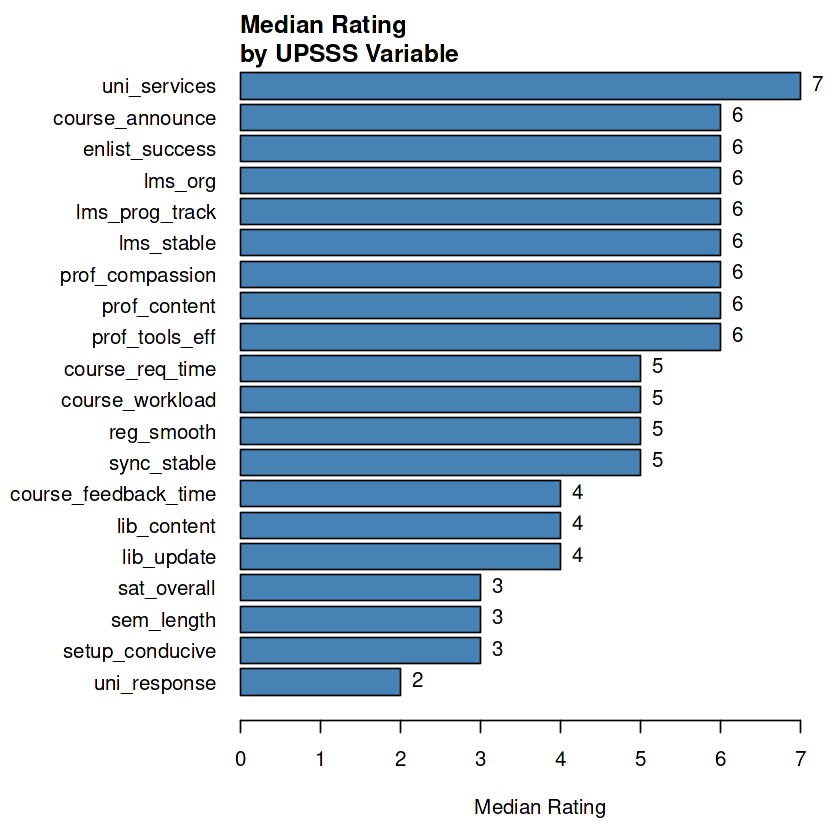

In [4]:
# Display summary statistics
upsss_long %>%
    group_by(item_code, variable) %>%
    summarize(n_students = n(),
              #mean_rating = mean(rating),
              min_rating = min(rating), 
              med_rating = median(rating),
              mode_rating = mode(rating),
              max_rating = max(rating),         
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_rating), variable)

# Display bar plot
horiz_barplot(
  data = upsss_long,
  variable = "variable",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian Rating\nby UPSSS Variable",
  xlab = "Median Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

constituent,n_students,min_upsss_rating,med_upsss_rating,mode_upsss_rating,max_upsss_rating,iqr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UP Open University,3,1,6,6,7,3.00
UP Baguio,4,1,5,5,7,2.00
UP Cebu,2,1,5,5,7,3.00
UP Diliman,103,1,5,6,7,3.00
UP Los Baños,30,1,5,7,7,3.00
UP Manila,5,1,5,7,7,2.25
UP Visayas,3,1,4,3,7,2.00


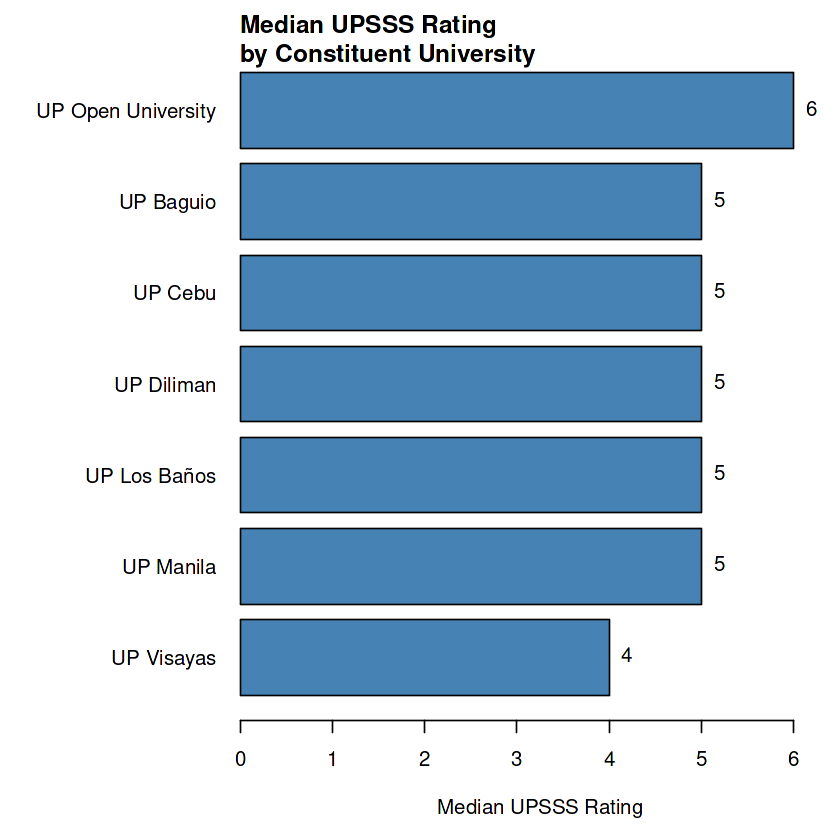

In [5]:
# Display summary statistics
upsss_long %>%
    group_by(constituent) %>%
    summarize(n_students = n()/20,
              min_upsss_rating = min(rating), 
              med_upsss_rating = median(rating),
              mode_upsss_rating = mode(rating),
              max_upsss_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_upsss_rating))

# Display bar plot
horiz_barplot(
  data = upsss_long,
  variable = "constituent",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian UPSSS Rating\nby Constituent University",
  xlab = "Median UPSSS Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

year_standing,n_students,min_upsss_rating,med_upsss_rating,mode_upsss_rating,max_upsss_rating,iqr
<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I,17,1,6,6,7,2
II,31,1,5,7,7,3
III,46,1,5,6,7,3
IV,52,1,5,6,7,2
V,4,1,5,7,7,3


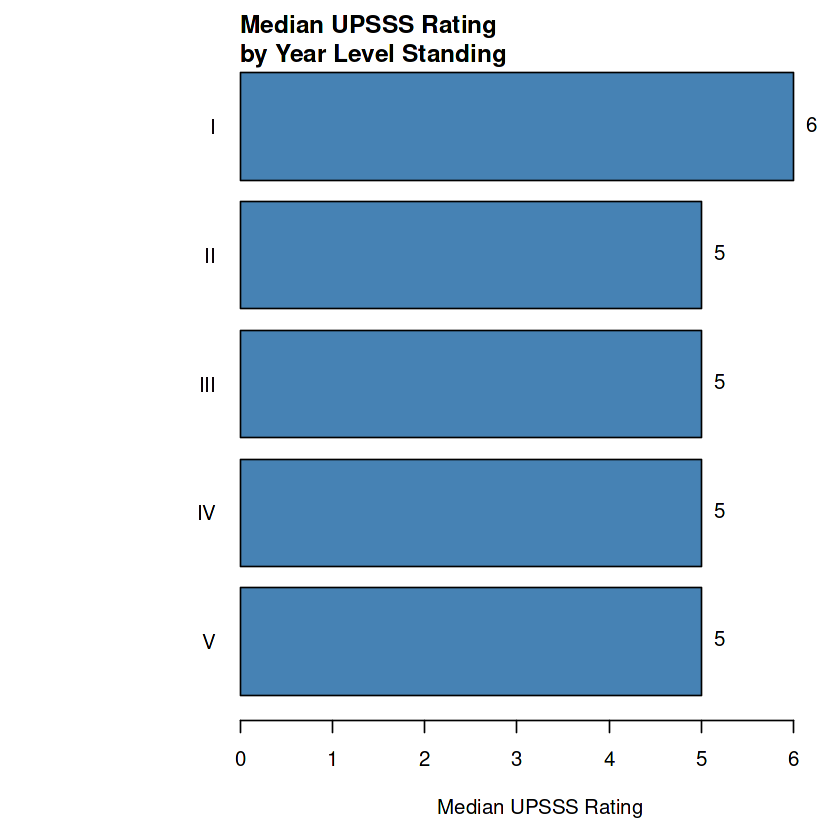

In [6]:
# Display summary statistics
upsss_long %>%
    group_by(year_standing) %>%
    summarize(n_students = n()/20,
              min_upsss_rating = min(rating), 
              med_upsss_rating = median(rating),
              mode_upsss_rating = mode(rating),
              max_upsss_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_upsss_rating))

# Display bar plot
horiz_barplot(
  data = upsss_long,
  variable = "year_standing",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian UPSSS Rating\nby Year Level Standing",
  xlab = "Median UPSSS Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

#### 2.1.3. Perceived Academic Performance
A student's level of agreement with the statements in the 7-item Student Perception on Academic Performance Scale (SPAPS), measured on a scale from 1 (Strongly Disagree) to 7 (Strongly Agree).

In [7]:
## Overall Perceived Academic Performance

# Compute median
med_spaps_ratingSum <- median(agg_data$spaps_ratingSum)

# Compute percent form
med_spaps_ratingSum_perc <- percent(med_spaps_ratingSum/49, accuracy=0.1)

# Print outputs
print(paste("Median SPAPS Rating Sum:", med_spaps_ratingSum, "(out of 49)"))
print(med_spaps_ratingSum_perc)

[1] "Median SPAPS Rating Sum: 30 (out of 49)"


[1] "61.2%"


item_code,variable,min_rating,med_rating,max_rating,iqr
<ord>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
spaps7,gwa_expected,1,5,7,3.00
spaps1,req_submit_time,1,5,7,3.00
spaps5,course_obj_achieve,1,4,7,2.00
spaps2,critical_thinking,1,4,7,2.00
spaps4,feedback_apply,1,4,7,2.75
spaps3,feedback_exchange,1,4,7,2.00
spaps6,study_daily,1,4,7,3.00


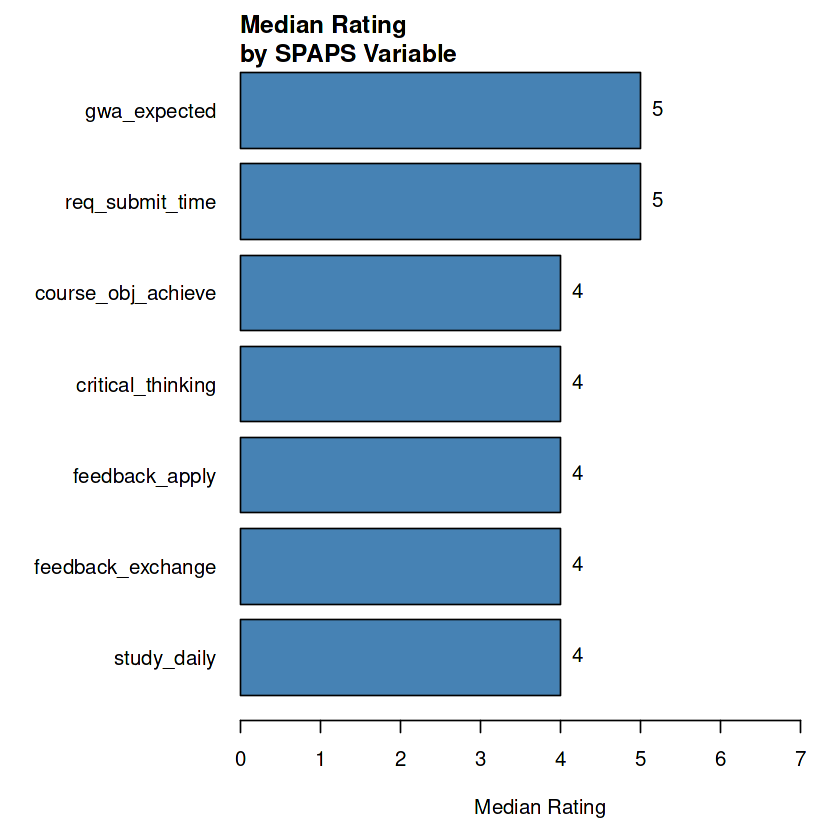

In [8]:
# Display summary statistics
spaps_long %>%
    group_by(item_code, variable) %>%
    summarize(min_rating = min(rating), 
              med_rating = median(rating),
              max_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_rating), variable)

# Display bar plot
horiz_barplot(
  data = spaps_long,
  variable = "variable",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian Rating\nby SPAPS Variable",
  xlab = "Median Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 2.5
)

constituent,n_students,min_spaps_rating,med_spaps_rating,mode_spaps_rating,max_spaps_rating,iqr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UP Cebu,2,2,5,5,7,2.75
UP Manila,5,1,5,6,7,2.50
UP Baguio,4,1,4,4,7,2.00
UP Diliman,103,1,4,5,7,2.00
UP Los Baños,30,1,4,5,7,2.00
UP Open University,3,1,4,1,7,4.00
UP Visayas,3,1,4,5,6,2.00


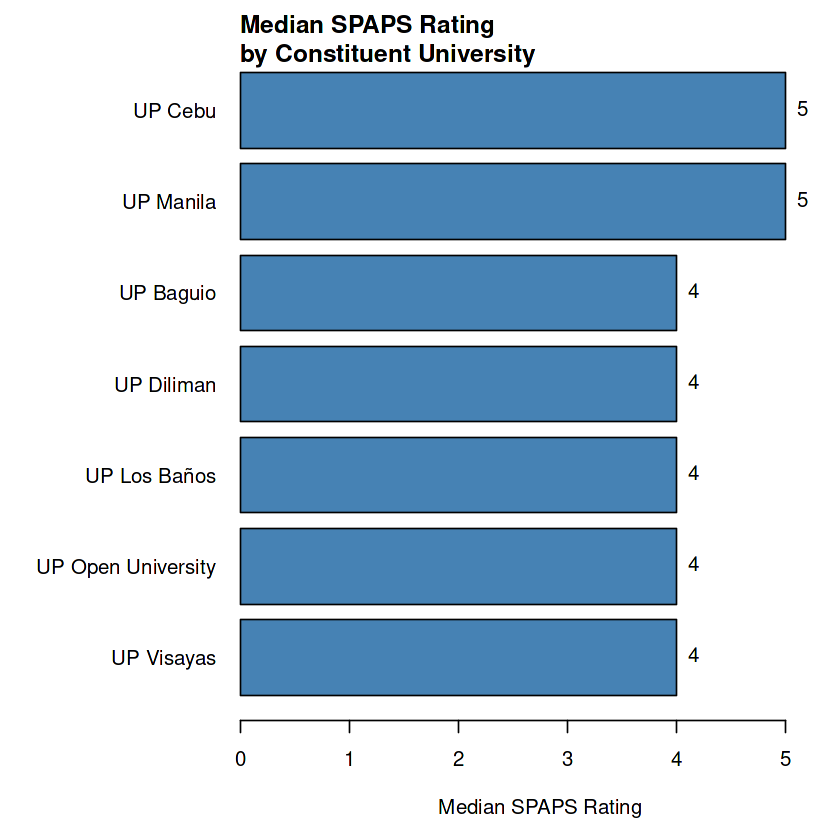

In [9]:
# Display summary statistics
spaps_long %>%
    group_by(constituent) %>%
    summarize(n_students = n()/7,
              min_spaps_rating = min(rating), 
              med_spaps_rating = median(rating),
              mode_spaps_rating = mode(rating),
              max_spaps_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_spaps_rating))

# Display bar plot
horiz_barplot(
  data = spaps_long,
  variable = "constituent",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian SPAPS Rating\nby Constituent University",
  xlab = "Median SPAPS Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

year_standing,n_students,min_spaps_rating,med_spaps_rating,mode_spaps_rating,max_spaps_rating,iqr
<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I,17,1,5.0,5,7,2.00
V,4,1,4.5,7,7,3.25
II,31,1,4.0,3,7,2.00
III,46,1,4.0,5,7,2.00
IV,52,1,4.0,4,7,2.00


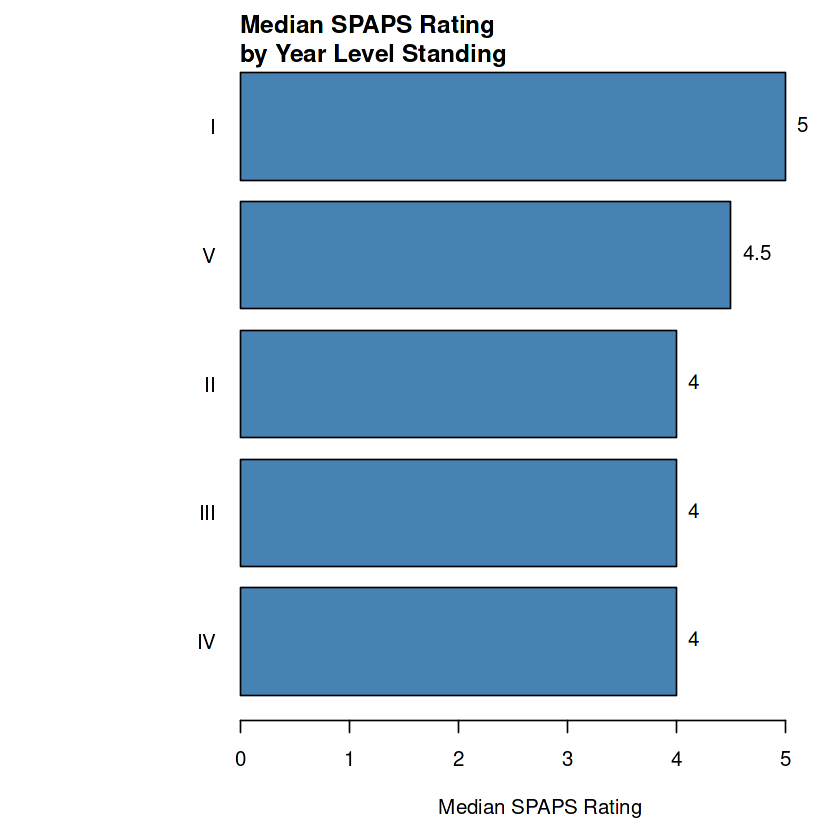

In [10]:
# Display summary statistics
spaps_long %>%
    group_by(year_standing) %>%
    summarize(n_students = n()/7,
              min_spaps_rating = min(rating), 
              med_spaps_rating = median(rating),
              mode_spaps_rating = mode(rating),
              max_spaps_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_spaps_rating))

# Display bar plot
horiz_barplot(
  data = spaps_long,
  variable = "year_standing",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian SPAPS Rating\nby Year Level Standing",
  xlab = "Median SPAPS Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

### 2.2. Correlation Analysis

A statistically significant weak to moderate positive correlation was found between SPAPS and UPSSS rating sums (Spearman's rank correlation coefficient = 0.51; Kendall's coefficient = 0.37; p<0.01). This suggests that higher student satisfaction with remote learning is associated with higher perceived academic performance.

In [11]:
## Test rank correlation of UPSSS and SPAPS rating sums

# Spearman
cor.test(
    x = agg_data$upsss_ratingSum,
    y = agg_data$spaps_ratingSum,
    method="spearman",
    exact=FALSE
)

# Kendall
cor.test(
    x = agg_data$upsss_ratingSum,
    y = agg_data$spaps_ratingSum,
    method="kendall"
)


	Spearman's rank correlation rho

data:  agg_data$upsss_ratingSum and agg_data$spaps_ratingSum
S = 275222, p-value = 2.444e-11
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5106947 



	Kendall's rank correlation tau

data:  agg_data$upsss_ratingSum and agg_data$spaps_ratingSum
z = 6.5459, p-value = 5.915e-11
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.3702111 


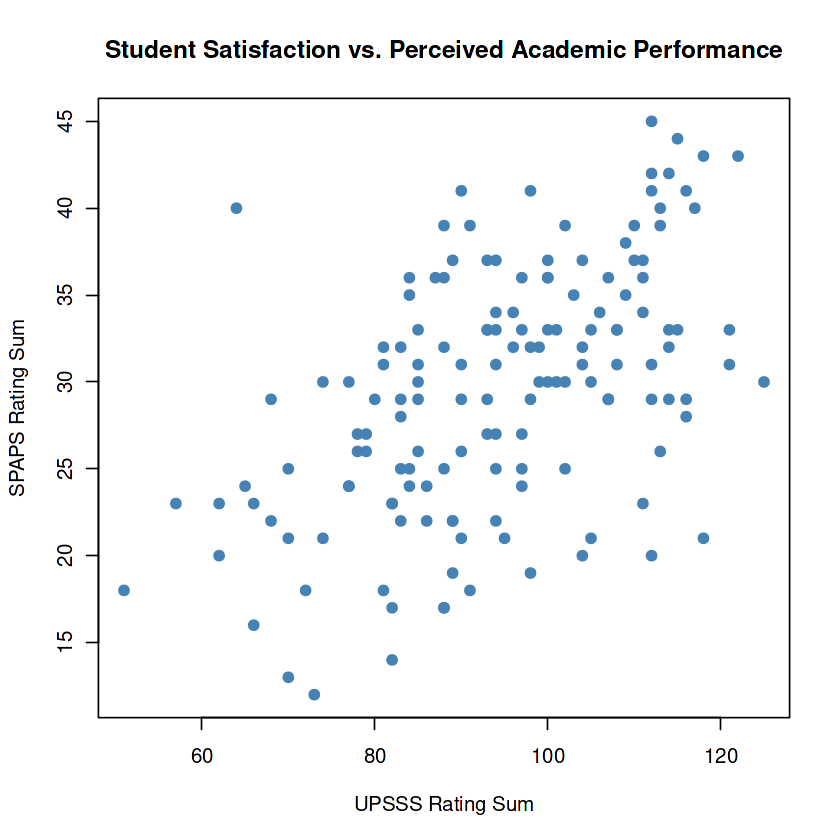

In [12]:
## Display scatterplot

#
plot(
    x = agg_data$upsss_ratingSum,
    y = agg_data$spaps_ratingSum,
    pch=19,
    col="steelblue",
    main="Student Satisfaction vs. Perceived Academic Performance",
    xlab="UPSSS Rating Sum",
    ylab="SPAPS Rating Sum"
)

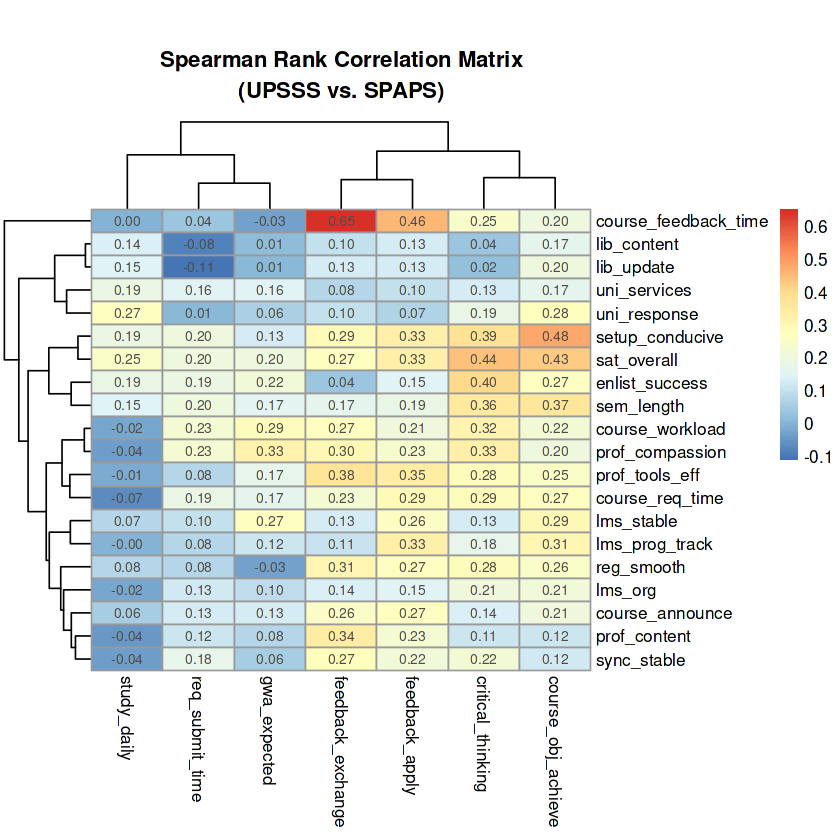

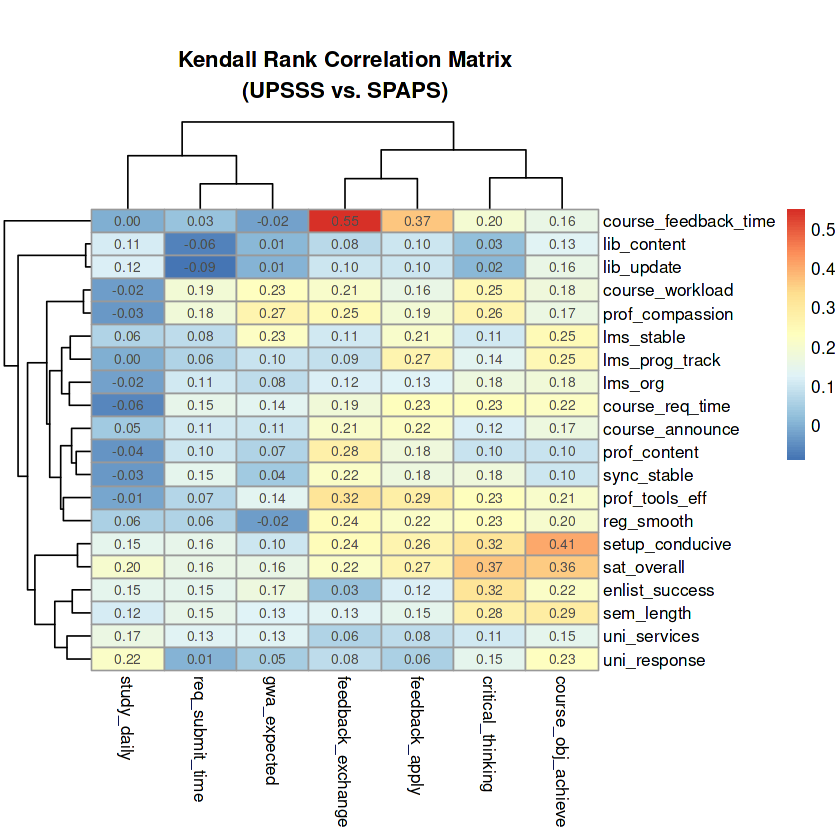

In [13]:
## (UPSSS vs. SPAPS) variables

# Join UPSSS and SPAPS data
upsss_spaps_wide <- upsss_wide %>%
    inner_join(spaps_wide, by="id") %>%
    select(-id)

# Rename columns
colnames(upsss_spaps_wide) <- c(upsss_descr$variable, spaps_descr$variable)

# Calculate the correlation matrices

# Spearman
spearmanCor_matrix <- upsss_spaps_wide %>%
  select(all_of(spaps_descr$variable), all_of(upsss_descr$variable)) %>%
  cor(method="spearman") 

# Kendall
kendallCor_matrix <- upsss_spaps_wide %>%
  select(all_of(spaps_descr$variable), all_of(upsss_descr$variable)) %>%
  cor(method="kendall")

# spearmanCor_matrix[c(8:27), c(1:7)]
# kendallCor_matrix[c(8:27), c(1:7)]

# Generate heatmaps

# Required library
# install.packages("pheatmap")
library(pheatmap)

# Spearman
pheatmap(
  spearmanCor_matrix[c(8:27), c(1:7)],
  main = "\nSpearman Rank Correlation Matrix\n(UPSSS vs. SPAPS)",
  #cluster_rows = FALSE,
  #cluster_cols = FALSE,
  display_numbers = TRUE
)

# Kendall
pheatmap(
  kendallCor_matrix[c(8:27), c(1:7)],
  main = "\nKendall Rank Correlation Matrix\n(UPSSS vs. SPAPS)",
  #cluster_rows = FALSE,
  #cluster_cols = FALSE,
  display_numbers = TRUE
)

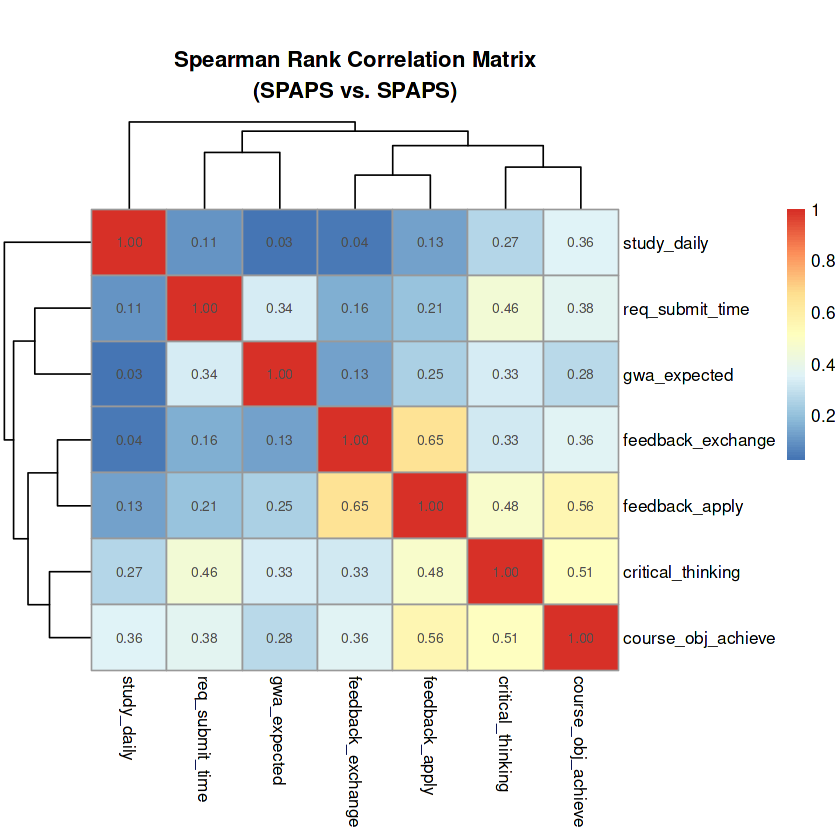

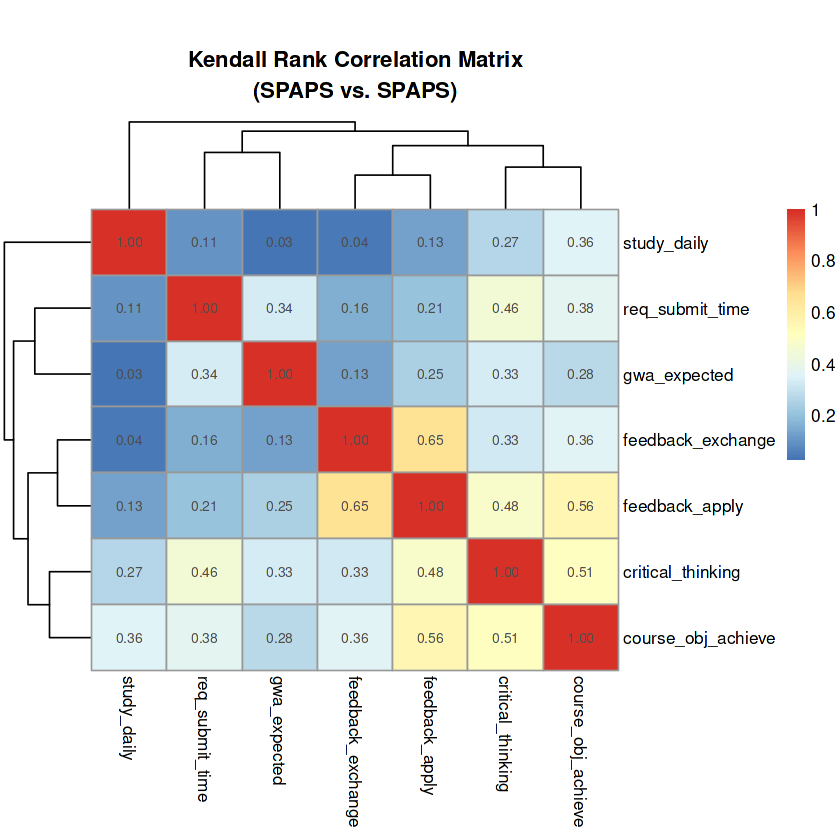

In [14]:
## (SPAPS vs. SPAPS) variables

# Spearman
pheatmap(
  spearmanCor_matrix[c(1:7), c(1:7)],
  main = "\nSpearman Rank Correlation Matrix\n(SPAPS vs. SPAPS)",
  #cluster_rows = FALSE,
  #cluster_cols = FALSE,
  display_numbers = TRUE
)

# Kendall
pheatmap(
  spearmanCor_matrix[c(1:7), c(1:7)],
  main = "\nKendall Rank Correlation Matrix\n(SPAPS vs. SPAPS)",
  #cluster_rows = FALSE,
  #cluster_cols = FALSE,
  display_numbers = TRUE
)